# Simple Matrix Factorization

In [3]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

In [4]:
df = pd.read_csv('data/small_preprocessed_rating.csv')
print(df.shape)

(2206428, 6)


In [5]:
df.head(3)

,userId,movieId,rating,newMovieId,SmallUserId,SmallNewMovieId
0,10,1,4.5,1,5,0
1,10,10,2.5,10,5,8
2,10,19,3.5,19,5,16


In [6]:
N = df.SmallUserId.max() + 1
M = df.SmallNewMovieId.max() + 1

In [7]:
# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# initialize variables
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0. # regularization penalty

In [8]:
# keras model

# Embed user and movie matrix
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # (N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # (N, 1, K)

# Bias terms
u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) # (N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # (N, 1, 1)

# (U @ M) + u + m
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

model = Model(inputs=[u, m], outputs=x)
model.compile(
    loss='mse',
    # optimizer='adam',
    # optimizer=Adam(lr=0.01),
    optimizer=SGD(lr=0.08, momentum=0.9),
    metrics=['mse'],
)

r = model.fit(
    x=[df_train.SmallUserId.values, df_train.SmallNewMovieId.values],
    y=df_train.rating.values - mu,
    epochs=epochs,
    batch_size=128,
    validation_data=(
        [df_test.SmallUserId.values, df_test.SmallNewMovieId.values],
        df_test.rating.values - mu
    )
)

Epoch 1/15


/Users/allenchen/miniforge3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-02-26 15:48:36.925112: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


13791/13791 [==============================] - 9s 623us/step - loss: 0.7461 - mse: 0.7461 - val_loss: 0.7043 - val_mse: 0.7043
Epoch 2/15
13791/13791 [==============================] - 8s 586us/step - loss: 0.7003 - mse: 0.7003 - val_loss: 0.6982 - val_mse: 0.6982
Epoch 3/15
13791/13791 [==============================] - 8s 595us/step - loss: 0.6811 - mse: 0.6811 - val_loss: 0.6631 - val_mse: 0.6631
Epoch 4/15
13791/13791 [==============================] - 8s 610us/step - loss: 0.6322 - mse: 0.6322 - val_loss: 0.6209 - val_mse: 0.6209
Epoch 5/15
13791/13791 [==============================] - 8s 607us/step - loss: 0.5896 - mse: 0.5896 - val_loss: 0.5987 - val_mse: 0.5987
Epoch 6/15
13791/13791 [==============================] - 8s 602us/step - loss: 0.5640 - mse: 0.5640 - val_loss: 0.5901 - val_mse: 0.5901
Epoch 7/15
13791/13791 [==============================] - 8s 598us/step - loss: 0.5494 - mse: 0.5494 - val_loss: 0.5857 - val_mse: 0.5857
Epoch 8/15
13791/13791 [=====================

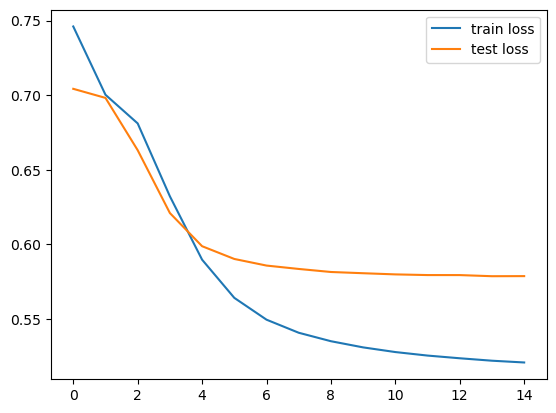

In [12]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()